1A

In [2]:
#!/usr/bin/env python

import numpy as np
from scipy.integrate import quad

def integrand_z(z):
    """
    Variable substitution x = z/(1-z) => z in [0,1).
    dx/dz = 1/(1-z)^2.
    The original integrand: x^3 / (exp(x) - 1).
    """
    x = z / (1 - z)
    dx_dz = 1.0 / (1 - z)**2

    # For large x, the term x^3 / (exp(x) - 1) is negligible, so return 0.
    # We'll pick a cutoff, say x>700 => integrand ~ 0.
    if x > 700:
        return 0.0
    val = np.exp(x)
    return (x**3 / (val - 1.0)) * dx_dz

def integrand_x(x):
    """
    Original integrand: x^3 / (exp(x) - 1).
    Again, clamp for large x to avoid overflow in exp(x).
    """
    if x > 700:
        return 0.0
    val = np.exp(x)
    return x**3 / (val - 1.0)

def main():
    # Integrate from z=0 to z=1 using the substitution
    I_z, err_z = quad(integrand_z, 0, 1)
    print(f"Integral (z-substitution) = {I_z:.6f}, err ~ {err_z:.2e}")

    # Integrate from x=0 to x=∞ directly
    I_x, err_x = quad(integrand_x, 0, np.inf)
    print(f"Integral (x from 0..∞)   = {I_x:.6f}, err ~ {err_x:.2e}")

    # Known exact result: π^4 / 15 ~ 6.493939
    exact = (np.pi**4) / 15
    print(f"Exact = {exact:.6f}")

if __name__ == "__main__":
    main()


Integral (z-substitution) = 6.493939, err ~ 6.58e-10
Integral (x from 0..∞)   = 6.493939, err ~ 2.63e-09
Exact = 6.493939


1B

In [4]:

import numpy as np
from scipy.integrate import fixed_quad

# Physical constants (SI units)
k_B   = 1.38064852e-23   # Boltzmann constant (J/K)
h     = 6.626e-34        # Planck's constant (J·s)
c     = 3.0e8            # Speed of light (m/s)
hbar  = h / (2.0 * np.pi)

def integrand_z(z):
    """
    Vectorized integrand for x = z/(1-z).
    x can be large => clamp at x=700 to avoid overflow in exp(x).
    """
    # z is an array => compute x elementwise
    x = z / (1.0 - z)
    dx_dz = 1.0 / (1.0 - z)**2

    # For large x, the integrand is negligible, so clamp x>700 to 700
    # This prevents overflow in exp(x).
    x_clamped = np.minimum(x, 700.0)
    val = np.exp(x_clamped)

    # Original formula: [x^3 / (exp(x)-1)] * dx/dz
    top = x**3
    denom = val - 1.0
    # Where x>700 => integrand ~ 0
    # We'll set those elements to 0 explicitly
    mask_large = (x > 700)
    out = (top / denom) * dx_dz
    out[mask_large] = 0.0
    return out

def main():
    # Integrate from z=0 to z=1 with fixed_quad
    integral_value, _ = fixed_quad(integrand_z, 0.0, 1.0, n=10)

    # Prefactor for Stefan-Boltzmann constant
    prefactor = (k_B**4) / (4.0 * (np.pi**2) * (c**2) * (hbar**3))
    sigma = prefactor * integral_value

    print(f"Integral Value = {integral_value:.6f}")
    print(f"Stefan-Boltzmann constant (calculated) = {sigma:.8e} W/m^2 K^4")

    # Compare with known value
    sigma_known = 5.670374419e-8
    print(f"Known Stefan-Boltzmann constant       = {sigma_known:.8e} W/m^2 K^4")
    error_percent = 100.0 * abs(sigma - sigma_known) / sigma_known
    print(f"Percent Error = {error_percent:.4f}%")

if __name__ == "__main__":
    main()


Integral Value = 6.572143
Stefan-Boltzmann constant (calculated) = 5.73089689e-08 W/m^2 K^4
Known Stefan-Boltzmann constant       = 5.67037442e-08 W/m^2 K^4
Percent Error = 1.0673%


1C

In [5]:

import numpy as np
from scipy.integrate import quad

def integrand_x(x):
    """
    Original integrand: x^3 / (exp(x) - 1), for x in [0, ∞).
    We'll clamp for x>700 to avoid overflow in exp(x).
    """
    if x > 700:
        return 0.0
    val = np.exp(x)
    return x**3 / (val - 1.0)

def main():
    # 1) Integrate from x=0 to x=∞ directly
    result_infinite, err_infinite = quad(integrand_x, 0.0, np.inf)
    print(f"quad => integral [0,∞] = {result_infinite:.6f}, err ~ {err_infinite:.2e}")

    # 2) Compare with the known exact value: π^4 / 15 ≈ 6.493939
    known_value = (np.pi**4) / 15
    print(f"Exact: π^4/15 = {known_value:.6f}")

    # 3) Print difference
    diff = abs(result_infinite - known_value)
    print(f"Absolute difference = {diff:.6e}")

if __name__ == "__main__":
    main()


quad => integral [0,∞] = 6.493939, err ~ 2.63e-09
Exact: π^4/15 = 6.493939
Absolute difference = 1.776357e-15


2A

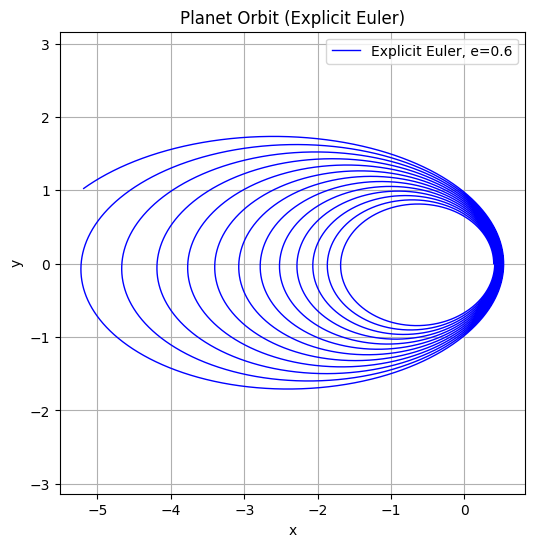

In [6]:
#!/usr/bin/env python

import numpy as np
import matplotlib.pyplot as plt

def explicit_euler_orbit(ecc=0.6, T=200.0, steps=100000):
    """
    Integrates a 2D Kepler-like orbit (central force ~ 1/r^2) using the
    explicit Euler method, for a planet of eccentricity 'ecc'.
    
    Returns arrays (x_vals, y_vals) with the trajectory over 'steps' points.
    """
    dt = T / steps

    # Initial position (x,y) and momentum (px,py)
    x0 = 1.0 - ecc
    y0 = 0.0
    px0 = 0.0
    py0 = np.sqrt((1.0 + ecc) / (1.0 - ecc))

    # Arrays to store the results
    x_vals = np.zeros(steps + 1)
    y_vals = np.zeros(steps + 1)
    px_vals = np.zeros(steps + 1)
    py_vals = np.zeros(steps + 1)

    # Set initial conditions
    x_vals[0], y_vals[0] = x0, y0
    px_vals[0], py_vals[0] = px0, py0

    # Time stepping loop: explicit (forward) Euler
    for n in range(steps):
        # Current distance from origin
        r = np.sqrt(x_vals[n]**2 + y_vals[n]**2)
        # Acceleration from central force
        ax = -x_vals[n] / (r**3)
        ay = -y_vals[n] / (r**3)

        # Update position using current momentum
        x_vals[n+1] = x_vals[n] + dt * px_vals[n]
        y_vals[n+1] = y_vals[n] + dt * py_vals[n]

        # Update momentum using current acceleration
        px_vals[n+1] = px_vals[n] + dt * ax
        py_vals[n+1] = py_vals[n] + dt * ay

    return x_vals, y_vals

def main():
    # Parameters
    eccentricity = 0.6
    final_time = 200.0
    num_steps = 100000

    # Run the explicit Euler integration
    x_traj, y_traj = explicit_euler_orbit(ecc=eccentricity, T=final_time, steps=num_steps)

    # Plot the orbit
    plt.figure(figsize=(6,6))
    plt.plot(x_traj, y_traj, 'b-', linewidth=1, label=f'Explicit Euler, e={eccentricity}')
    plt.title('Planet Orbit (Explicit Euler)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')
    plt.grid(True)
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()


2B

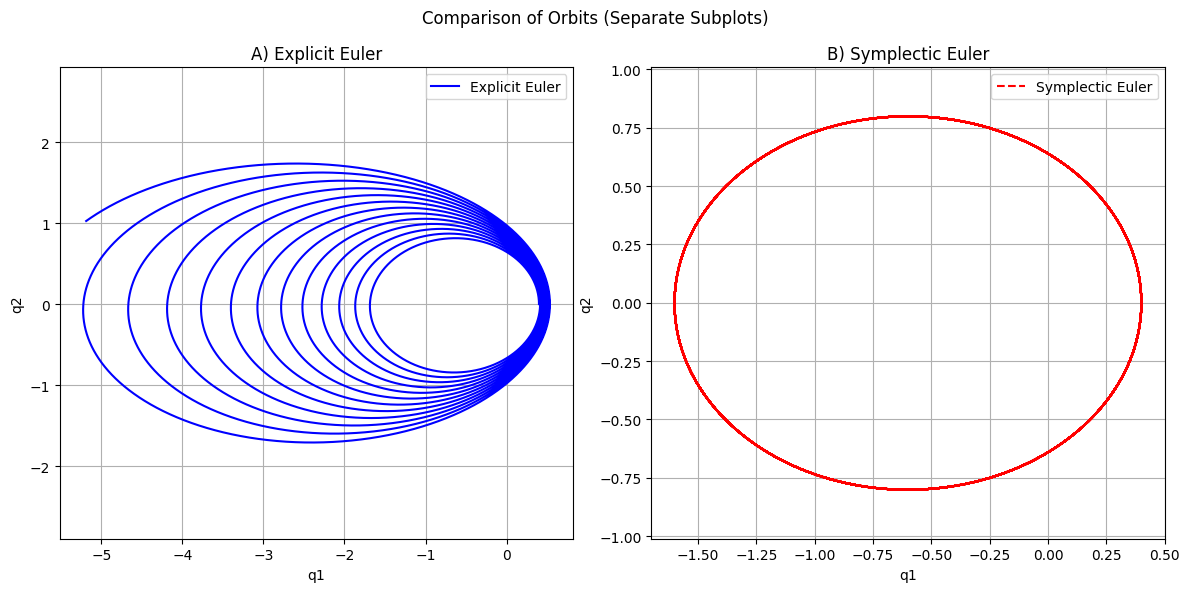

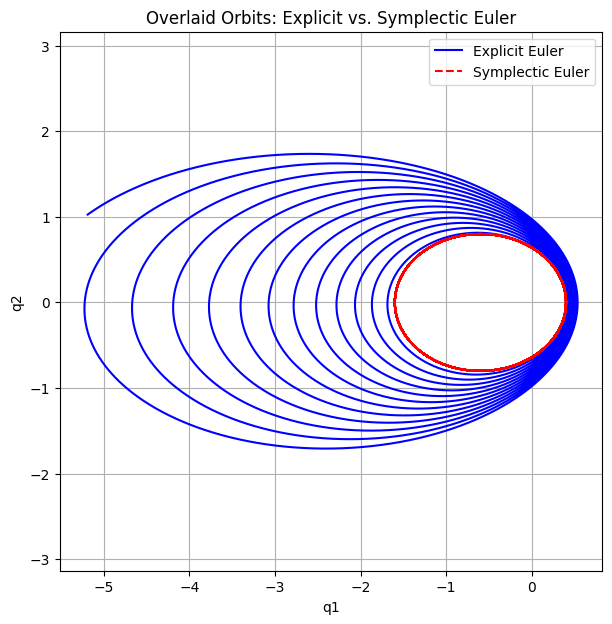

In [9]:
#!/usr/bin/env python

import numpy as np
import matplotlib.pyplot as plt

def explicit_euler_orbit(e=0.6, T=200.0, steps=100000):
    dt = T / steps
    # Initial conditions
    q1_0, q2_0 = 1.0 - e, 0.0
    p1_0, p2_0 = 0.0, np.sqrt((1.0 + e)/(1.0 - e))

    q1 = np.zeros(steps+1)
    q2 = np.zeros(steps+1)
    p1 = np.zeros(steps+1)
    p2 = np.zeros(steps+1)

    q1[0], q2[0] = q1_0, q2_0
    p1[0], p2[0] = p1_0, p2_0

    for n in range(steps):
        r = np.sqrt(q1[n]**2 + q2[n]**2)
        # a = -q/r^3 => partial derivative wrt q
        a1 = -q1[n] / r**3
        a2 = -q2[n] / r**3

        # Explicit Euler
        q1[n+1] = q1[n] + dt*p1[n]
        q2[n+1] = q2[n] + dt*p2[n]
        p1[n+1] = p1[n] + dt*a1
        p2[n+1] = p2[n] + dt*a2

    return q1, q2

def symplectic_euler_orbit(e=0.6, T=200.0, steps=400000):
    dt = T / steps
    # Initial conditions
    q1_0, q2_0 = 1.0 - e, 0.0
    p1_0, p2_0 = 0.0, np.sqrt((1.0 + e)/(1.0 - e))

    q1 = np.zeros(steps+1)
    q2 = np.zeros(steps+1)
    p1 = np.zeros(steps+1)
    p2 = np.zeros(steps+1)

    q1[0], q2[0] = q1_0, q2_0
    p1[0], p2[0] = p1_0, p2_0

    for n in range(steps):
        r = np.sqrt(q1[n]**2 + q2[n]**2)
        a1 = -q1[n]/r**3
        a2 = -q2[n]/r**3

        # Symplectic Euler: kick, then drift
        p1[n+1] = p1[n] + dt*a1
        p2[n+1] = p2[n] + dt*a2
        q1[n+1] = q1[n] + dt*p1[n+1]
        q2[n+1] = q2[n] + dt*p2[n+1]

    return q1, q2

def main():
    # Solve A) (Explicit) and B) (Symplectic)
    q1_exp, q2_exp = explicit_euler_orbit(e=0.6, T=200.0, steps=100000)
    q1_sym, q2_sym = symplectic_euler_orbit(e=0.6, T=200.0, steps=400000)

    # 1) Subplots: Show each method in its own subplot
    fig, (axA, axB) = plt.subplots(1, 2, figsize=(12,6))

    axA.plot(q1_exp, q2_exp, 'b-', label='Explicit Euler')
    axA.set_title("A) Explicit Euler")
    axA.set_xlabel("q1")
    axA.set_ylabel("q2")
    axA.axis("equal")
    axA.grid(True)
    axA.legend()

    axB.plot(q1_sym, q2_sym, 'r--', label='Symplectic Euler')
    axB.set_title("B) Symplectic Euler")
    axB.set_xlabel("q1")
    axB.set_ylabel("q2")
    axB.axis("equal")
    axB.grid(True)
    axB.legend()

    plt.suptitle("Comparison of Orbits (Separate Subplots)")
    plt.tight_layout()
    plt.show()

    # 2) Single figure with both orbits overlaid
    plt.figure(figsize=(7,7))
    plt.plot(q1_exp, q2_exp, 'b-', label='Explicit Euler')
    plt.plot(q1_sym, q2_sym, 'r--', label='Symplectic Euler')
    plt.title("Overlaid Orbits: Explicit vs. Symplectic Euler")
    plt.xlabel("q1")
    plt.ylabel("q2")
    plt.axis("equal")
    plt.grid(True)
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()


3A

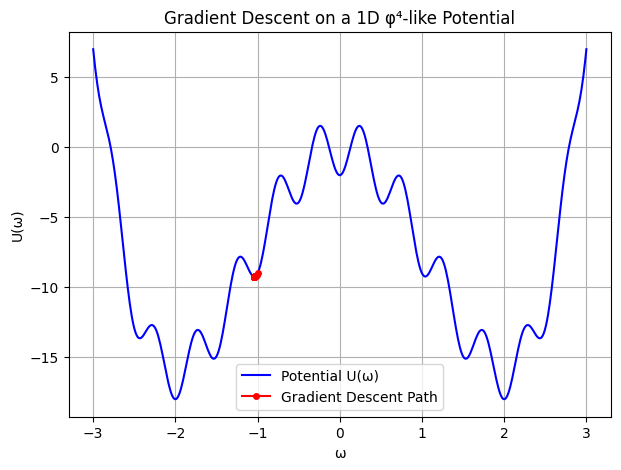

In [10]:
#!/usr/bin/env python

import numpy as np
import matplotlib.pyplot as plt

# Potential for a 1D φ^4-like theory (inspired by the provided code, but not copied verbatim).
# Example: U(ω) = ω^4 - 8ω^2 - 2 cos(4π ω)
def potential(omega):
    return omega**4 - 8.0 * omega**2 - 2.0 * np.cos(4.0 * np.pi * omega)

# Derivative dU/dω
def grad_potential(omega):
    return 4.0 * omega**3 - 16.0 * omega + (8.0 * np.pi) * np.sin(4.0 * np.pi * omega)

def gradient_descent(phi0, step_size=0.001, max_steps=10000, tol=1e-6):
    """
    Basic gradient descent:
      phi_{n+1} = phi_n - step_size * grad(U)(phi_n).
    Returns the array of phi-values at each iteration.
    """
    phi_vals = [phi0]
    current = phi0

    for _ in range(max_steps):
        g = grad_potential(current)
        new_phi = current - step_size * g
        phi_vals.append(new_phi)

        if abs(new_phi - current) < tol:
            break
        current = new_phi

    return np.array(phi_vals)

def main():
    # Choose an initial guess
    init_guess = -1.0

    # Run gradient descent
    trajectory = gradient_descent(phi0=init_guess, step_size=0.001, max_steps=10000, tol=1e-6)

    # Plot the potential curve plus the descent trajectory
    x_range = np.linspace(-3, 3, 500)
    y_vals = potential(x_range)

    plt.figure(figsize=(7,5))
    plt.plot(x_range, y_vals, 'b-', label='Potential U(ω)')
    plt.plot(trajectory, potential(trajectory), 'ro-', markersize=4, label='Gradient Descent Path')
    plt.xlabel('ω')
    plt.ylabel('U(ω)')
    plt.title('Gradient Descent on a 1D φ⁴-like Potential')
    plt.grid(True)
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()


3B

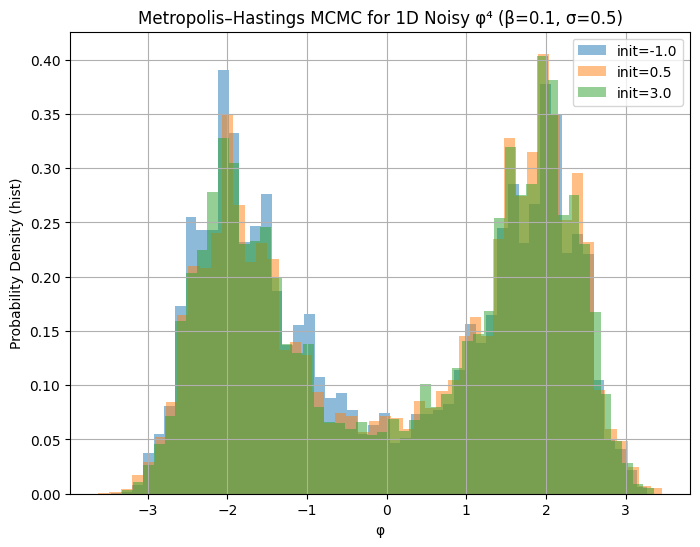

In [11]:
#!/usr/bin/env python

import numpy as np
import matplotlib.pyplot as plt

# A simple 1D "noisy φ^4" potential, inspired by the earlier code
def potential(phi):
    # Example: U(φ) = φ^4 - 8 φ^2 - 2 cos(4 π φ)
    return phi**4 - 8.0 * phi**2 - 2.0 * np.cos(4.0 * np.pi * phi)

def metropolis_hastings_mcmc(phi0, beta=0.1, proposal_sigma=0.5, steps=10000):
    """
    1D Metropolis–Hastings MCMC sampling from the Boltzmann distribution:
      P(φ) ∝ exp[-β * U(φ)].

    phi0: initial position
    beta: inverse temperature (1/kT)
    proposal_sigma: std. dev. for the normal proposal N(0, proposal_sigma^2)
    steps: total MCMC iterations

    Returns:
      chain: array of shape (steps,) with the accepted φ values
    """
    chain = np.zeros(steps)
    chain[0] = phi0

    current_U = potential(phi0)

    for i in range(1, steps):
        # Propose a new φ by adding a Gaussian deviate
        proposal = chain[i-1] + np.random.normal(0, proposal_sigma)
        proposal_U = potential(proposal)

        # Metropolis acceptance ratio r = e^[-β (U(proposal) - U(current))]
        dU = proposal_U - current_U
        r = np.exp(-beta * dU)

        # Accept if r > 1 or random < r
        if r > 1.0 or np.random.rand() < r:
            chain[i] = proposal
            current_U = proposal_U
        else:
            # reject => stay at old position
            chain[i] = chain[i-1]

    return chain

def main():
    # We'll try a few initial guesses and betas
    initial_values = [-1.0, 0.5, 3.0]
    beta = 0.1       # inverse temperature
    sigma = 0.5      # proposal step size
    steps = 20000    # total MCMC steps

    plt.figure(figsize=(8,6))

    for init_phi in initial_values:
        chain = metropolis_hastings_mcmc(phi0=init_phi, beta=beta,
                                         proposal_sigma=sigma, steps=steps)
        # Plot the final chain or a histogram of visited φ
        plt.hist(chain[int(0.2*steps):], bins=50, alpha=0.5, density=True,
                 label=f'init={init_phi}')

    plt.title(f"Metropolis–Hastings MCMC for 1D Noisy φ⁴ (β={beta}, σ={sigma})")
    plt.xlabel("φ")
    plt.ylabel("Probability Density (hist)")
    plt.grid(True)
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()


3C

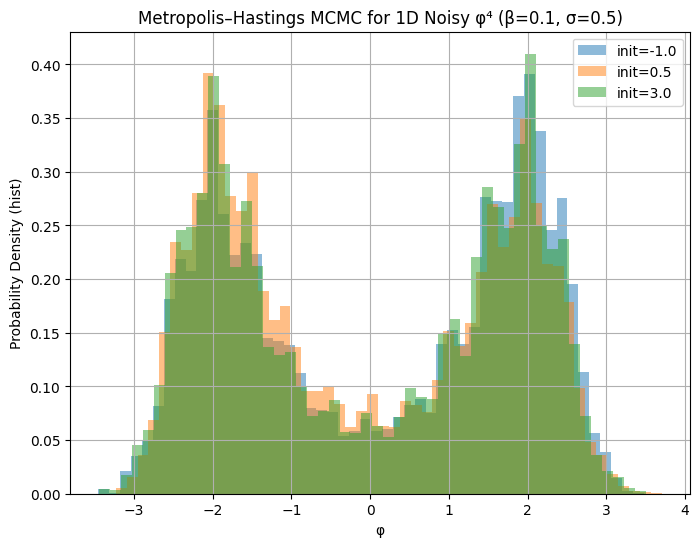

In [12]:
#!/usr/bin/env python

import numpy as np
import matplotlib.pyplot as plt

# A simple 1D "noisy φ^4" potential, inspired by the earlier code
def potential(phi):
    # Example: U(φ) = φ^4 - 8 φ^2 - 2 cos(4 π φ)
    return phi**4 - 8.0 * phi**2 - 2.0 * np.cos(4.0 * np.pi * phi)

def metropolis_hastings_mcmc(phi0, beta=0.1, proposal_sigma=0.5, steps=10000):
    """
    1D Metropolis–Hastings MCMC sampling from the Boltzmann distribution:
      P(φ) ∝ exp[-β * U(φ)].

    phi0: initial position
    beta: inverse temperature (1/kT)
    proposal_sigma: std. dev. for the normal proposal N(0, proposal_sigma^2)
    steps: total MCMC iterations

    Returns:
      chain: array of shape (steps,) with the accepted φ values
    """
    chain = np.zeros(steps)
    chain[0] = phi0

    current_U = potential(phi0)

    for i in range(1, steps):
        # Propose a new φ by adding a Gaussian deviate
        proposal = chain[i-1] + np.random.normal(0, proposal_sigma)
        proposal_U = potential(proposal)

        # Metropolis acceptance ratio r = e^[-β (U(proposal) - U(current))]
        dU = proposal_U - current_U
        r = np.exp(-beta * dU)

        # Accept if r > 1 or random < r
        if r > 1.0 or np.random.rand() < r:
            chain[i] = proposal
            current_U = proposal_U
        else:
            # reject => stay at old position
            chain[i] = chain[i-1]

    return chain

def main():
    # We'll try a few initial guesses and betas
    initial_values = [-1.0, 0.5, 3.0]
    beta = 0.1       # inverse temperature
    sigma = 0.5      # proposal step size
    steps = 20000    # total MCMC steps

    plt.figure(figsize=(8,6))

    for init_phi in initial_values:
        chain = metropolis_hastings_mcmc(phi0=init_phi, beta=beta,
                                         proposal_sigma=sigma, steps=steps)
        # Plot the final chain or a histogram of visited φ
        plt.hist(chain[int(0.2*steps):], bins=50, alpha=0.5, density=True,
                 label=f'init={init_phi}')

    plt.title(f"Metropolis–Hastings MCMC for 1D Noisy φ⁴ (β={beta}, σ={sigma})")
    plt.xlabel("φ")
    plt.ylabel("Probability Density (hist)")
    plt.grid(True)
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()
